In [1]:
using DataFrames
using CSV
using Plots
using ModelingToolkit, OrdinaryDiffEq, LinearAlgebra
using DifferentialEquations
using DataDrivenDiffEq
using DataDrivenSparse
using StatsPlots
using Statistics
using Distributions
using Dates
using DSP
using RecursiveArrayTools
using DiffEqParamEstim
using Optimization, OptimizationOptimJL
using OptimizationBBO
using ForwardDiff
using TotalVariation

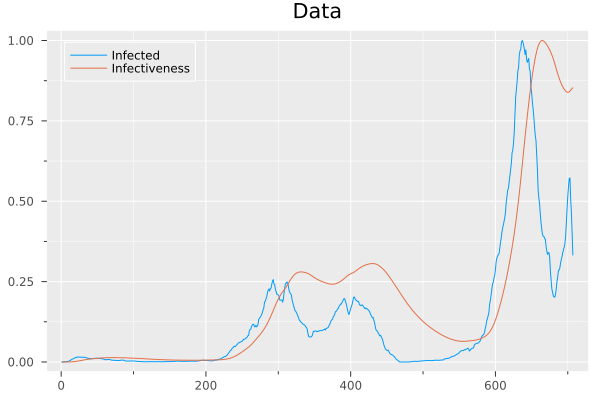

In [2]:
#################### Making the Data #######################################
theme(:ggplot2)
###### it must be 1 to 350(first year) or 350 to 680 (second year)
start_training=350
finish_training=680 
##### specify the range you want to chop out for prediction
split_start=590
split_finish=620

begin
    #707 days are recorded
    raw_data=CSV.File("Thuringen_SIRD_2.csv") |> DataFrame
    data=Matrix(raw_data[:,[2, 3]])'
    #@df raw_data plot(:Date, :Infected)
      

    ############# Beta distribution
    #d=Beta(1.5,2.5)
    #plot(d)

    function factors(α, β, n) ## Beta distribution, coefficients for n days needed (Infected)
        d=Beta(α, β)
        max=pdf(d, mode(d))
        step=1/(n+2-1)
        steps=collect(0.0:step: 1.0)
        coefs=zeros(length(steps))
        for i in eachindex(coefs)
            coefs[i]=pdf(d,steps[i])/max
        end
        return steps[2:end-1], coefs[2:end-1]
    end

    n=21  #### number of days that infection rate of each patient changes
    vals, cofs=factors(2.5,4.5,n) #### α=1.5 and β=2.5, we can change the curve shape by changing α and β

    #plot(cofs)
    #plot(data')
    ###############################  factors should be  used ######################

    infectiveness=zeros(size(data)[2],1);
    infectiveness=conv(cofs, data[1,:])[1:length(infectiveness)]
   
    #smoothing the infectiveness
    for i in eachindex(infectiveness)
        infectiveness[i]=mean(infectiveness[max(i-10,1):min(end, i)])
    end

  
    data1=copy(data)
    data1[2,:]=infectiveness
    Max_data1=[maximum(data1[i,1:end]) for i in 1:size(data1)[1]]
    Min=0#minimum(data)
    for i in 1:size(data1)[1]
        for j in 1:size(data1)[2]
            data1[i,j]=(data1[i,j]-Min)/(Max_data1[i]-Min)
        end
    end 
    data2=data1[:,start_training:split_start]
    data3=data1[:,split_finish:finish_training]
    #data2=data1[:,start_training:finish_training]
    #### I D
    X1=copy(data2)
    X2=copy(data3)

    #smoothing the X
    s=size(X1)[2]
    for i in 1:s
        X1[1,i]=mean(X1[1,max(1,i-3):min(s,i+3)])
    end
    s=size(X2)[2]
    for i in 1:s
        X2[1,i]=mean(X2[1,max(1,i-3):min(s,i+3)])
    end
    plot(data1', title="Data", label=["Infected" "Infectiveness"])
end

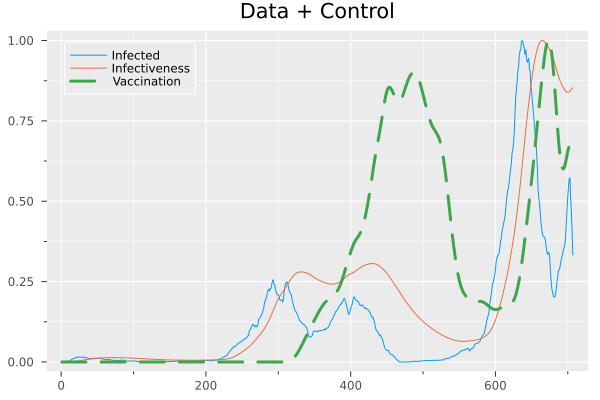

In [3]:
############################# Making control signal ########################
begin
    v_raw_data=CSV.File("Thuringen_daily_vaccination.csv") |> DataFrame
    v_data=Matrix{Float64}(v_raw_data[:,3:5])'
    #@df v_raw_data plot!(:Date, :Total/10)

   
    ####  weekly averaging
     avg_days=7
    s=size(v_data)
    weekly=Matrix{Float64}(undef,s[1], s[2])
    for i in 1:size(v_data)[1]
        weekly[i,:]=[mean(v_data[i, max(j-avg_days,1):j]) for j in 1:s[2]]'
    end
    #avg_days=7
   
    ############# beta distribution  

    n=35 ## number of days needed to reach the peak of antibody and then goes down after vaccination
    vvals, vcofs=factors(3,4,n) #### α=4 and β=4, we can change the curve shape by changing α and β
    #plot(vcofs)


    ###############################  factors should be reversed and used ######################
    dose1=zeros(size(v_data)[2],1);
    dose2=zeros(size(v_data)[2],1);
    dose3=zeros(size(v_data)[2],1);

    vcofs1=reverse(vcofs)
    for i in 1:lastindex(dose1)
        for j in 1:min(n,i)-1
            dose1[i]=dose1[i] + weekly[1, i-j] * vcofs1[j]
            dose2[i]=dose2[i] + weekly[2, i-j] * vcofs1[j]
            dose3[i]=dose3[i] + weekly[3, i-j] * vcofs1[j]
        end 
    end

    dose11=zeros(size(raw_data)[1],1);
    dose21=zeros(size(raw_data)[1],1);
    dose31=zeros(size(raw_data)[1],1);

    difference=Dates.value(v_raw_data[1,1]-raw_data[1,1])
    
    for i in difference+1:lastindex(dose11)
        dose11[i]=dose1[i-difference]
        dose21[i]=dose2[i-difference]
        dose31[i]=dose3[i-difference]
    end

    #control=vcat(dose11', dose21', dose31') ### used in prediction
    antibody=dose11.+dose21.+ dose31

    Max_antibody=maximum(antibody)
    Min=0#minimum(v_data)
    for i in 1:size(antibody)[1]       
        antibody[i]=(antibody[i]-Min)/(Max_antibody-Min)
    end

    control=vcat(antibody') ### used in prediction
    control1=vcat(antibody[start_training:split_start]')
    control2=vcat(antibody[split_finish:finish_training]')
    
    plot!(control', lw=3, ls=:dash, title="Data + Control", label="Vaccination")
end

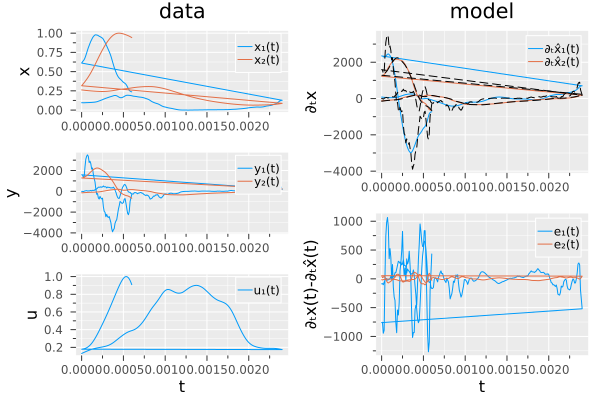

In [4]:
######################## definition and solving of the problem ##################
begin
    tick=100000
    t1=collect(0.0:1/tick:(split_start-start_training)/tick);
    itp_method=InterpolationMethod(LinearInterpolation)
    #sir_problem1=ContinuousDataDrivenProblem(X1, t1, itp_method, U = control1)

    t2=collect(0.0:1/tick:(finish_training-split_finish)/tick);
    #sir_problem2=ContinuousDataDrivenProblem(X2, t2, itp_method, U = control2)
    
    final_data=(prob1=(X=X1, t=t1, itp_method, U=control1), prob2=(X=X2, t=t2, itp_method, U=control2))
    sir_problem=ContinuousDataset(final_data)#(sir_problem1, sir_problem2

    @variables u[1:2] c[1:1]
    u = collect(u)
    c = collect(c)

    if start_training<350
        h = Num[polynomial_basis([u; c], 1);]# exp(c[1]);exp(c[2]);exp(c[3]);]
    else
        h = Num[polynomial_basis([u; c], 2);]
    end

    basis = Basis(h, u, controls=c)


    ### choosing STLSQ as an optimizer
    ### STLSQ is a sparsifying algorithm that cause the solve function to call its "Sindy" method ###
    opt = STLSQ(exp10.(-8:0.01:-1))


    #sampler = DataProcessing(split = 0.95, shuffle=true, batchsize = 70, rng = rng)

    ddsol = solve(sir_problem, basis, opt)
    plot(plot(sir_problem, title="data"),plot(ddsol, title="model"), layout=(1,2))
   
end

In [5]:
################## recovering the dynamic########################
begin
    ##### range of prediction ####
    start=split_start
    finish=split_finish
    
    
    res=ddsol
    sys = get_basis(res)
    #println(sys)

    # Optimal parameters
    p_opt = get_parameter_values(sys)
    #p_opt=params_regularised[:,43]
    z0=X1[:,end]#data1[:,start]

    ztspan=(start/tick,finish/tick)

    #control[:,286:300].=0.2

    function get_dose1(t)
        return control[1, Int(round(t*tick+1,RoundDown))]
    end

    function get_total_antibody(t)
        down=control[1, Int(round(t*tick+1, RoundDown))]
        up=control[1, Int(round(t*tick+1, RoundUp))]
        down_co=t*tick-round(t*tick,RoundDown)
        up_co=1-down_co
        control_in_t=down_co*down+up_co*up
        return control_in_t

        #return control[1, Int(round(t+1))]
    end

    # Generate a closure on the system 
    f_recovered = let doese_1 = get_total_antibody
        (x, p, t) -> sys(x, p, t, [doese_1.(t)])
    end
    sys    
end

Model ##Basis#299 with 2 equations
States (2):
  u[1]
  u[2]
Parameters (20):
  p₁
  p₂
  p₃
  p₄
⋮

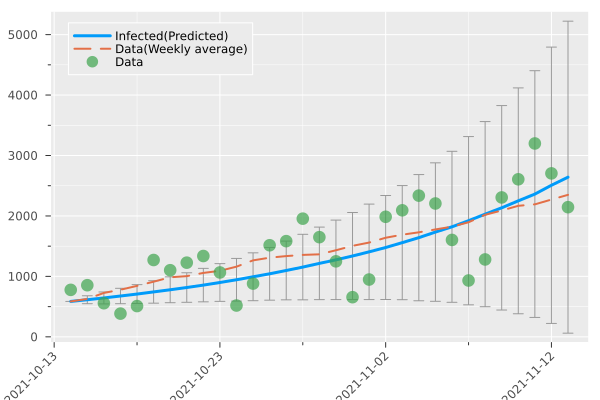

In [6]:
#################### stochastic #########################
begin
    raw_data_end=CSV.File("Thuringen_SIRD_raw_2.csv") |> DataFrame
    data_end=Matrix(raw_data_end[:,[2, 3]])'
    t_step=1/tick
    beta=40
    g(u,p,t)=beta*u   #### stochastic function and its parameters

    ################## StatsPlots ################
    y1 = fill(NaN, finish-start+1, 5000);
    y2 = fill(NaN, finish-start+1, 5000);
    y3 = fill(NaN, finish-start+1, 5000);
    for i  in 1:5000
        prediction_prob = SDEProblem(f_recovered, g, z0, ztspan, p_opt)
        prediction = solve(prediction_prob, EM(), dt=t_step)
        M=Matrix(prediction)
        #tmp=extractInfected(M[1,:], start, finish, data[1,:], cofs)
        y1[:,i]=max.(M[1,:].-(z0[1]-data1[1,start]),0)
        #y1[:,i]=M[1,:]
        y2[:,i]=M[2,:]
        #y3[:,i]=M[3,:]
    end

    errorline(1:finish-start+1, y1[:,:]*Max_data1[1], errorstyle=:stick, label="Infected(Predicted)", lw=3)
    plot!(data1[1,start:finish]*Max_data1[1], label="Data(Weekly average)", lw=2, ls=:dash)
    scatter!(data_end[1,start:finish], label="Data",  ms=7, ma=0.7)
    dates=raw_data[start:finish,1]
    plot!(xformatter= x->Dates.format(dates[Int(round(x+1, RoundDown))], "yyyy-mm-dd"), xrot=45)
end

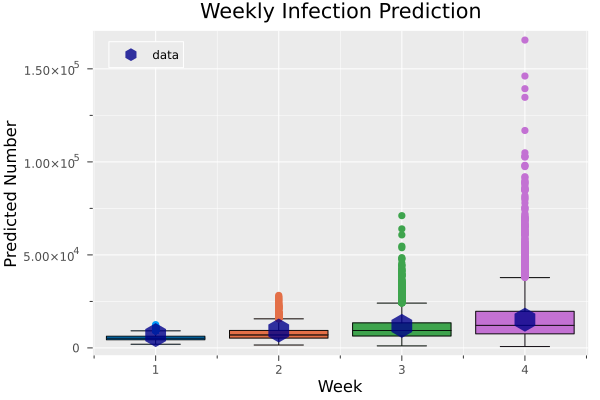

In [7]:
#################### weekly prediction #######################
begin
    test=[]
    d=[]
    xt=Int[]
    c=0
    for i in 1:finish-start+1
        if i%7==0
            test1=y1[i,:].*7*Max_data1[1]
            push!(test, test1)
            d1=data1[1,start+i-1].*7*Max_data1[1]
            push!(d,d1)
            c=c+1
            push!(xt, c)
        end
    end
    boxplot(test, xlabel="Week", ylabel="Predicted Number", label=false)
    scatter!(d, m=(0.8, :hex, 12), label="data", color=:darkblue, title="Weekly Infection Prediction")
    xticks!(xt)
end

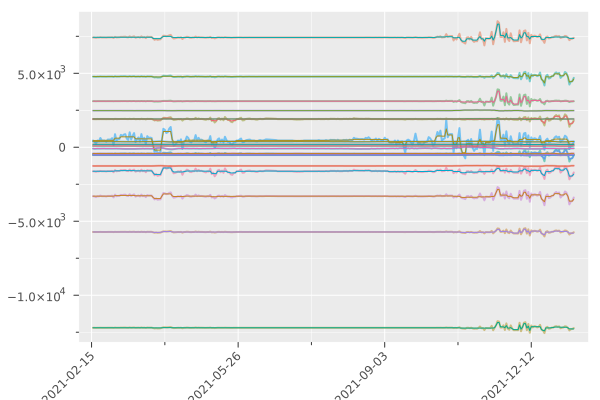

In [8]:
########### Optmimization of the coeffients and then Total Variation Regularization #############
begin
    p=get_parameter_values(sys)
    prms=[]
    push!(prms, p)
    window=1
    for step in 1:finish_training-start_training-window-1
        new_data=data1[:,start_training+step:start_training+window+step]
        u0=data1[:,start_training+step]
        #tspan=((start-added_days)/tick,finish/tick)
        tspan=((start_training+step)/tick, (start_training+window+step)/tick)
        t=collect((start_training+step)/tick:1/tick:(start_training+window+step)/tick)
        #random p
        problem=ODEProblem(f_recovered, u0, tspan, p)


        ########## Objective Function for Optim.jl ##################
        #t1=collect(0.0:1.0:500)
        cost_function=build_loss_objective(problem, Tsit5(), L2Loss(t, new_data),
                                            Optimization.AutoForwardDiff(),
                                            maxiters=10000, verbose=false)

        ###### Optimization of the Parameter ###############################################
        optprob=Optimization.OptimizationProblem(cost_function, p)
        optsol=solve(optprob, BFGS())
        push!(prms, optsol.u)
        #p=optsol.u
    end
    params1=reduce(hcat, prms)
    params_regularised=copy(params1);

    for i in 1:size(params_regularised)[1]
        params_regularised[i,:]=tv(params1[i,:],std(params1[i,:]))
    end

    plot(params1[:,:]', legend=false, alpha=0.5, lw=2)
    plot!(params_regularised[:,:]', legend=false)
    dates=raw_data[start_training:finish_training-window-1,1]
    plot!(xformatter= x->Dates.format(dates[Int(round(x+1, RoundDown))], "yyyy-mm-dd"), xrot=45)
end